In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using device: cuda
Processing content image: /content/drive/MyDrive/input_img.jpg
With style image: /content/drive/MyDrive/Vincent_van_Gogh-Zwei_Bäuerinnen_bei_der_Kartoffelernte-03986.jpg
Building the style transfer model..
Optimizing..


<ipython-input-7-1d339a73e8b5>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-7-1d339a73e8b5>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 2.166452 Content Loss: 6.790922

run [100]:
Style Loss : 0.697008 Content Loss: 5.771888

run [150]:
Style Loss : 0.470119 Content Loss: 5.301792

run [200]:
Style Loss : 0.374147 Content Loss: 5.079743

run [250]:
Style Loss : 0.328173 Content Loss: 4.948706

run [300]:
Style Loss : 0.299116 Content Loss: 4.866390

run [350]:
Style Loss : 0.280390 Content Loss: 4.811181

run [400]:
Style Loss : 0.265835 Content Loss: 4.771464

run [450]:
Style Loss : 0.256988 Content Loss: 4.742901

run [500]:
Style Loss : 0.248244 Content Loss: 4.722695

Stylized image saved to: /content/drive/MyDrive/stylized_output/input_img_styled_by_Vincent_van_Gogh-Zwei_Bäuerinnen_bei_der_Kartoffelernte-03986.jpg


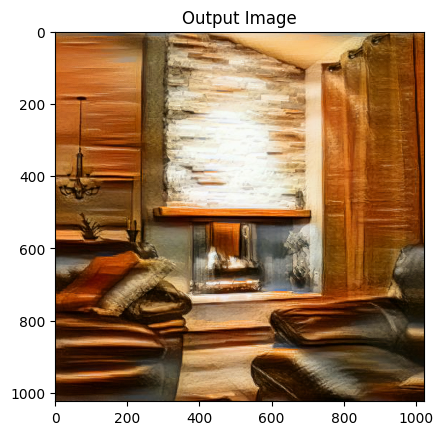

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

import copy
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

imsize = 1024
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')

    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()


cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

    normalization = Normalization(normalization_mean, normalization_std).to(device)


    content_losses = []
    style_losses = []


    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:

            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:

            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)


    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():

            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)


    input_img.data.clamp_(0, 1)

    return input_img


if __name__ == '__main__':

    # Choose one style image from your 'high_quality_images' folder

    style_img_path = "/content/drive/MyDrive/Vincent_van_Gogh-Zwei_Bäuerinnen_bei_der_Kartoffelernte-03986.jpg"

    # Choose one content image from your 'image_content' folder (COCO images)

    content_img_path = "/content/drive/MyDrive/input_img.jpg"

    output_dir = "/content/drive/MyDrive/stylized_output"
    os.makedirs(output_dir, exist_ok=True)


    style_name = os.path.splitext(os.path.basename(style_img_path))[0]
    content_name = os.path.splitext(os.path.basename(content_img_path))[0]
    output_img_name = os.path.join(output_dir, f"{content_name}_styled_by_{style_name}.jpg")


    if not os.path.exists(style_img_path):
        print(f"ERROR: Style image not found at {style_img_path}")
        exit()
    if not os.path.exists(content_img_path):
        print(f"ERROR: Content image not found at {content_img_path}")
        exit()

    style_img = image_loader(style_img_path)
    content_img = image_loader(content_img_path)

    assert style_img.size() == content_img.size(), \
        "We need to import style and content images of the same size for this tutorial version"


    input_img = content_img.clone()

    print(f"Processing content image: {content_img_path}")
    print(f"With style image: {style_img_path}")

    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style_img, input_img, num_steps=500) # Start with 300 steps


    save_image(output, output_img_name)
    print(f"Stylized image saved to: {output_img_name}")


    plt.figure()
    unloader = transforms.ToPILImage() # Reconvert into PIL image
    plt.imshow(unloader(output.cpu().clone().squeeze(0)))
    plt.title('Output Image')
    plt.ioff()
    plt.show()
